In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from  sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.model_selection import train_test_split

KeyboardInterrupt: ignored

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'axes.grid': False})

In [ ]:
df = pd.read_csv('bina_az_data.csv').set_index('elan_id')

In [ ]:
df.head()

,kateqoriya,mertebe,otaq_say,sahe,qiymet,kvm_qiymet,adres,baxis_say,cixarish,satici,ipoteka,elan_basliq,info
elan_id,,,,,,,,,,,,,
2969337,Yeni tikili,2 / 7,5,110 m²,248 000 AZN,2 250 AZN/m²,Şah İsmayıl Xətai m.,91,var,ilkanBəy,yoxdur,"Satılır 5 otaqlı yeni tikili 110 m², Şah İsmay...",Təcili satılır! Xetai metrosu Estetik klinikan...
2801416,Yeni tikili,13 / 19,4,141 m²,280 000 AZN,1 990 AZN/m²,İnşaatçılar m.,296,var,Cavid M.,yoxdur,"Satılır 4 otaqlı yeni tikili 141 m², İnşaatçıl...","COOX COX TECILI Yasamal rayonu,Hesen bey Zarda..."
2903445,Köhnə tikili,3 / 5,2,58 m²,86 000 AZN,1 480 AZN/m²,Memar Əcəmi m.,1030,var,Hüseyn m,yoxdur,"Satılır 2 otaqlı köhnə tikili 58 m², Memar Əcə...",COOX COX TECILI Nesimi rayonu Huseyn Seyidzade...
2969332,Yeni tikili,9 / 15,3,194 m²,475 000 AZN,2 450 AZN/m²,Şah İsmayıl Xətai m.,79,var,ilkanBəy,yoxdur,"Satılır 3 otaqlı yeni tikili 194 m², Şah İsmay...",MƏNZİL SATILIR!!!Ş. İ. Xətai metrosunun yaxınl...
2969329,Köhnə tikili,1 / 5,1,35 m²,58 500 AZN,1 670 AZN/m²,Neftçilər m.,436,var,Aysel,yoxdur,"Satılır 1 otaqlı köhnə tikili 35 m², Neftçilər m.",1 otaq səlqəli evdir kirə ümün əl vetişlidir ö...


In [ ]:
df.shape

(59339, 13)

In [ ]:
df.dtypes

kateqoriya     object
mertebe        object
otaq_say        int64
sahe           object
qiymet         object
kvm_qiymet     object
adres          object
baxis_say       int64
cixarish       object
satici         object
ipoteka        object
elan_basliq    object
info           object
dtype: object

### Feature generation & Preprocessing

#### Yeni feature-lar yaradaq

In [ ]:
df['mertebe_bina'] = df.mertebe.apply(lambda x: x.split('/')[1].strip()).astype(int)
df['valyuta'] = df['qiymet'].apply(lambda x: x.split(' ')[-1].strip())

df['info'] = df['info'].astype(str)

df['info'] = df['info'].apply(lambda x: x.lower())

df_tecili = df[df['info'].str.contains('tecili') | df['info'].str.contains('təcili')]

temp_df = df.copy(deep=True)
df = temp_df.merge(df_tecili[['info']], on='elan_id', how='left', suffixes=['', '_x'])
df['tecili'] = df['info_x'].isna().apply(lambda x: 1 if x is False else 0)
df = df.drop(['info_x'], axis=1)

NameError: ignored

#### Featurelarimizi uygun data tiplerine cevirek

In [ ]:
df['mertebe'] = df.mertebe.apply(lambda x: x.split('/')[0].strip()).astype(int)
df['sahe'] = df['sahe'].apply(lambda x: x.split(' ')[0]).astype(float)
df['qiymet'] = df['qiymet'].apply(lambda x: ''.join(x.split(' ')[:-1])).astype(int)
df['kvm_qiymet'] =df['kvm_qiymet'].apply(lambda x: ''.join(x.split(' ')[:-1])).astype(float)
df['cixarish'] = df['cixarish'].apply(lambda x: 1 if x == 'var' else 0)
df['ipoteka'] = df['ipoteka'].apply(lambda x: 1 if x == 'var' else 0)

In [ ]:
df.dtypes

In [ ]:
df.head()

In [ ]:
df.valyuta.value_counts()

In [ ]:
df = df.drop('valyuta',axis=1)

In [ ]:
df.isna().sum()

In [ ]:
df[df.duplicated()].shape

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.shape

In [ ]:
df.describe()

### Data visualization

In [ ]:
df.qiymet.describe()

count     59336.000
mean     205609.476
std      173591.780
min          83.000
25%      118000.000
50%      164000.000
75%      245000.000
max     8075000.000
Name: qiymet, dtype: float64

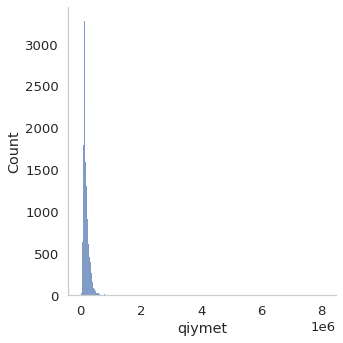

In [ ]:
# target deyerimiz right skewed formadadi
sns.displot(data=df,x='qiymet')
plt.show()

In [ ]:
kateqoriya_qrup = df.groupby('kateqoriya')

In [ ]:
kateqoriya_qrup['qiymet'].agg(['min','max','std','var','mean'])

,min,max,std,var,mean
kateqoriya,,,,,
Köhnə tikili,83,4200000,94029.360,8841520589.398,132934.096
Yeni tikili,500,8075000,186927.405,34941854877.278,230168.900


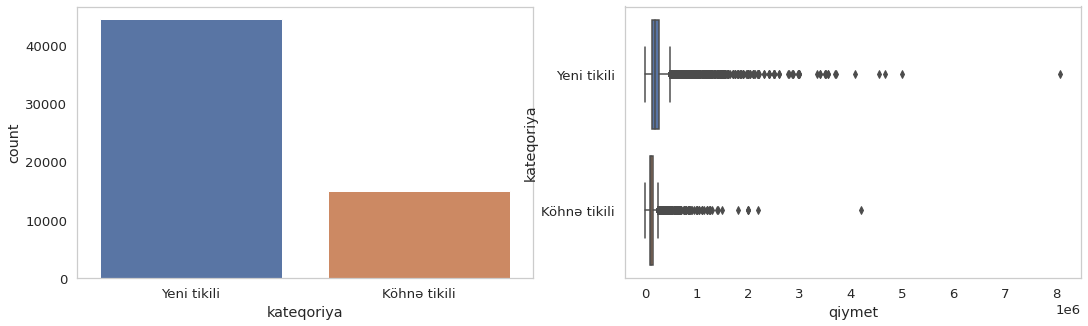

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
sns.countplot(data=df, x='kateqoriya', ax=ax[0])
sns.boxplot(data=df, x="qiymet",y='kateqoriya',ax=ax[1])
plt.show()

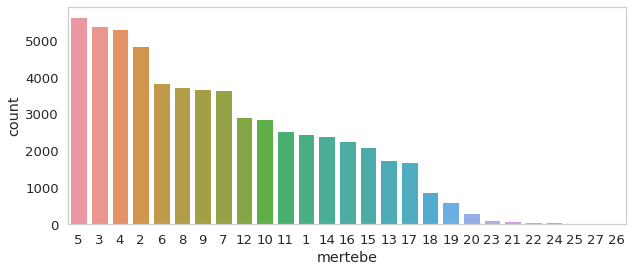

In [ ]:
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='mertebe',order=df.mertebe.value_counts(ascending=False).index)
plt.show()

In [ ]:
# mertebe_qiymet = pd.DataFrame(df.groupby('mertebe')['qiymet'].mean()).reset_index()
# mertebe_qiymet[(mertebe_qiymet.qiymet == mertebe_qiymet.qiymet.max()) | (mertebe_qiymet.qiymet == mertebe_qiymet.qiymet.min())]

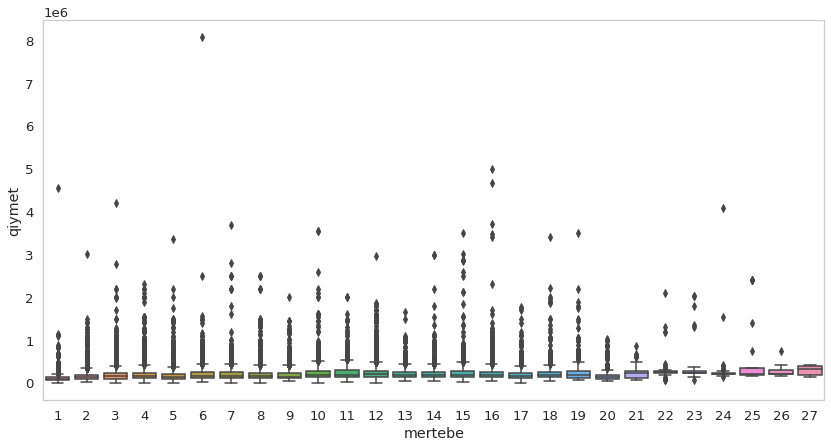

In [ ]:
plt.figure(figsize=(14,7))
sns.boxplot(data=df, x="mertebe",y='qiymet')
plt.show()

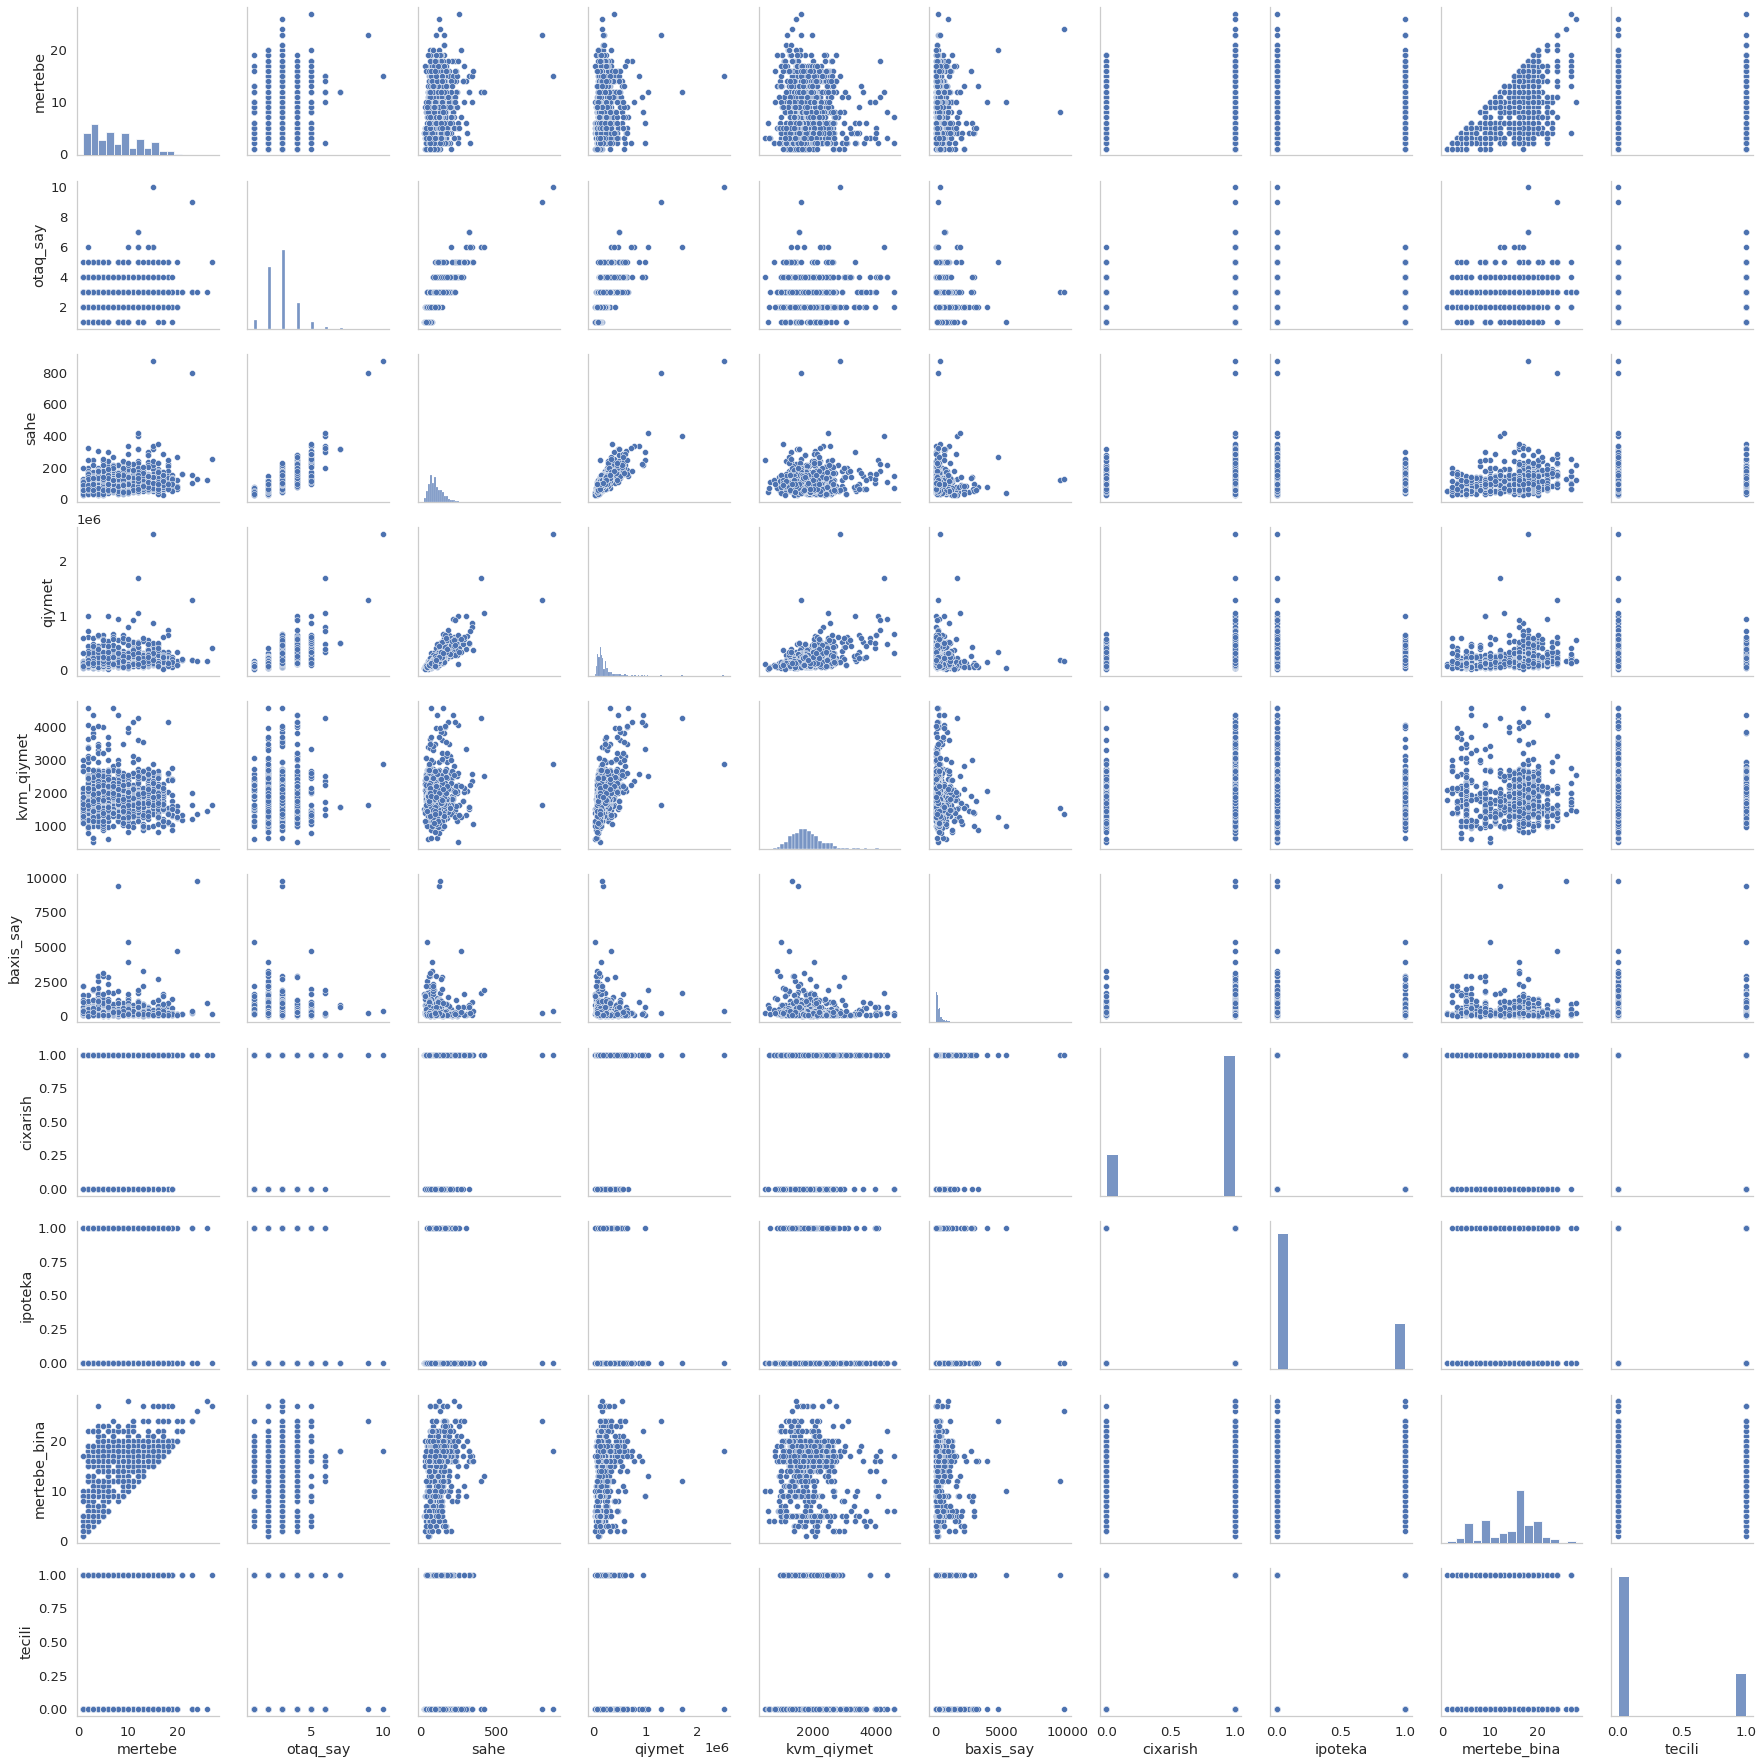

In [ ]:
sns.pairplot(df.sample(1000))
plt.show()

In [ ]:
df.corr()['qiymet']

mertebe         0.138
otaq_say        0.561
sahe            0.027
qiymet          1.000
kvm_qiymet      0.562
baxis_say       0.055
cixarish        0.039
ipoteka        -0.018
mertebe_bina    0.243
tecili         -0.072
Name: qiymet, dtype: float64

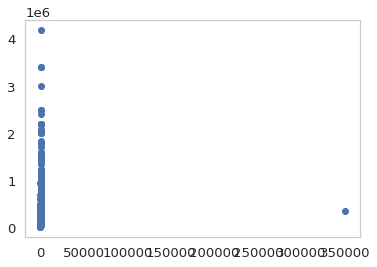

In [ ]:
temp = df.sample(10000)
plt.scatter(x=temp.sahe,y=temp.qiymet)
plt.show()

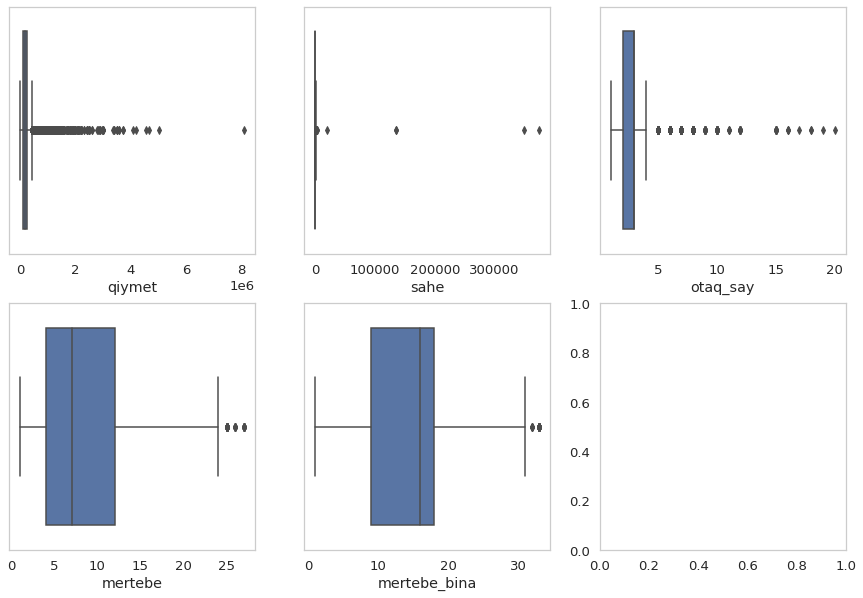

In [ ]:
# Outlier Analysis
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
plt1 = sns.boxplot(data=df,x='qiymet', ax=axs[0, 0])
plt2 = sns.boxplot(data=df,x='sahe', ax=axs[0, 1])
plt3 = sns.boxplot(data=df,x='otaq_say', ax=axs[0, 2])
plt1 = sns.boxplot(data=df,x='mertebe', ax=axs[1, 0])
plt2 = sns.boxplot(data=df,x='mertebe_bina', ax=axs[1, 1])

plt.show()

#### Sahede dehset outlierler var

           min      max       mean
ipoteka                           
0           83  8075000 207434.291
1        15000  5000000 200261.238


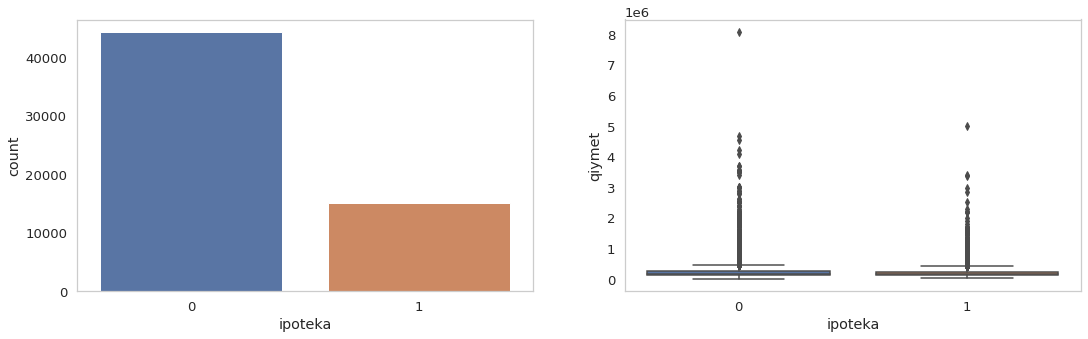

In [ ]:
print(df.groupby('ipoteka')['qiymet'].agg(['min','max','mean']))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
sns.countplot(data=df, x='ipoteka', ax=ax[0])
sns.boxplot(data=df, x="ipoteka",y='qiymet',ax=ax[1])
plt.show()

          min      max       mean
cixarish                         
0          83  2600000 192843.363
1         500  8075000 209235.349


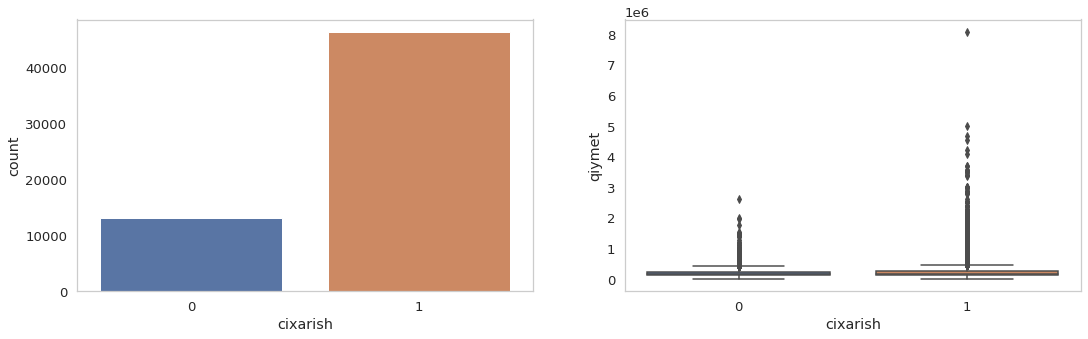

In [ ]:
print(df.groupby('cixarish')['qiymet'].agg(['min','max','mean']))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
sns.countplot(data=df, x='cixarish', ax=ax[0])
sns.boxplot(data=df, x="cixarish",y='qiymet',ax=ax[1])
plt.show()

        min      max       mean
tecili                         
0        83  8075000 212402.775
1        88  3000000 182720.360


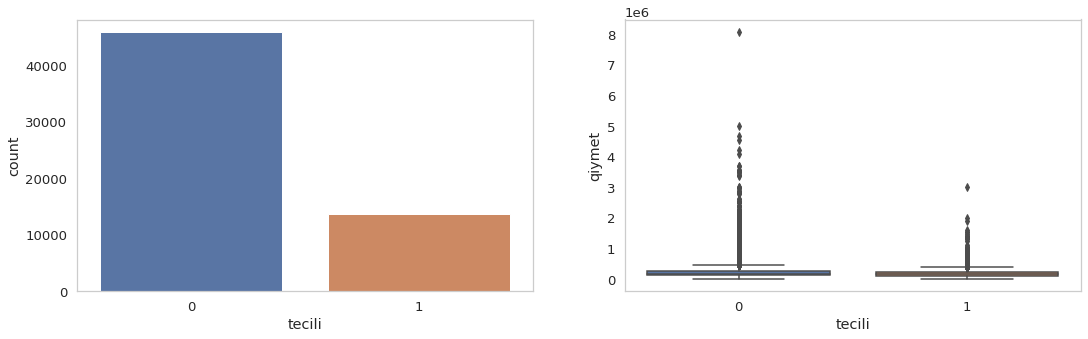

In [ ]:
print(df.groupby('tecili')['qiymet'].agg(['min','max','mean']))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
sns.countplot(data=df, x='tecili', ax=ax[0])
sns.boxplot(data=df, x="tecili",y='qiymet',ax=ax[1])
plt.show()

In [ ]:
adresses = df.adres.value_counts()[0:20].index.values
adres_df = df[df.adres.isin(adresses)]
adres_df.head()

,kateqoriya,mertebe,otaq_say,sahe,qiymet,kvm_qiymet,adres,baxis_say,cixarish,satici,ipoteka,elan_basliq,info,mertebe_bina,tecili
elan_id,,,,,,,,,,,,,,,
2969337,Yeni tikili,2,5,110.000,248000,2250.000,Şah İsmayıl Xətai m.,91,1,ilkanBəy,0,"Satılır 5 otaqlı yeni tikili 110 m², Şah İsmay...",təcili satılır! xetai metrosu estetik klinikan...,7,1
2801416,Yeni tikili,13,4,141.000,280000,1990.000,İnşaatçılar m.,296,1,Cavid M.,0,"Satılır 4 otaqlı yeni tikili 141 m², İnşaatçıl...","coox cox tecili yasamal rayonu,hesen bey zarda...",19,1
2903445,Köhnə tikili,3,2,58.000,86000,1480.000,Memar Əcəmi m.,1030,1,Hüseyn m,0,"Satılır 2 otaqlı köhnə tikili 58 m², Memar Əcə...",coox cox tecili nesimi rayonu huseyn seyidzade...,5,1
2969332,Yeni tikili,9,3,194.000,475000,2450.000,Şah İsmayıl Xətai m.,79,1,ilkanBəy,0,"Satılır 3 otaqlı yeni tikili 194 m², Şah İsmay...",mənzi̇l satilir!!!ş. i̇. xətai metrosunun yaxı...,15,0
2969329,Köhnə tikili,1,1,35.000,58500,1670.000,Neftçilər m.,436,1,Aysel,0,"Satılır 1 otaqlı köhnə tikili 35 m², Neftçilər m.",1 otaq səlqəli evdir kirə ümün əl vetişlidir ö...,5,0


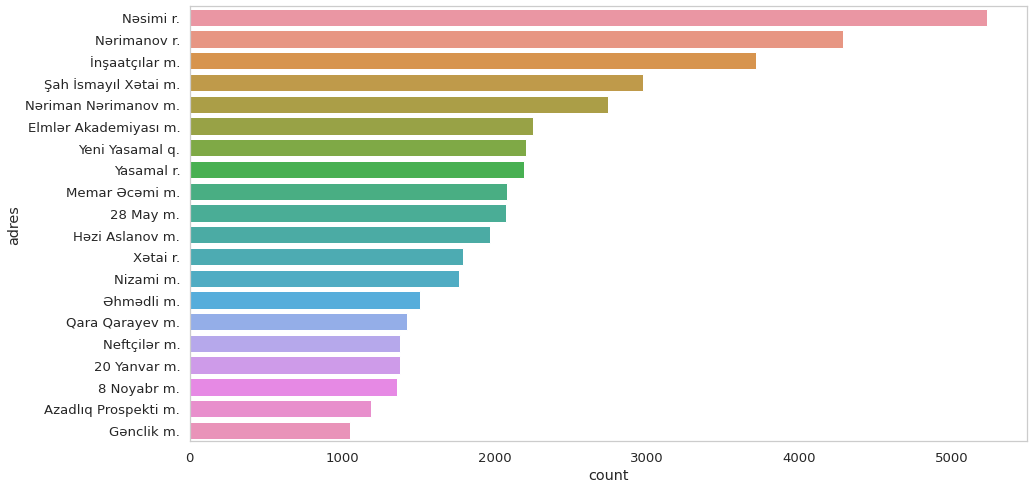

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(data=adres_df, y='adres',order=adres_df.adres.value_counts().index)
plt.show()

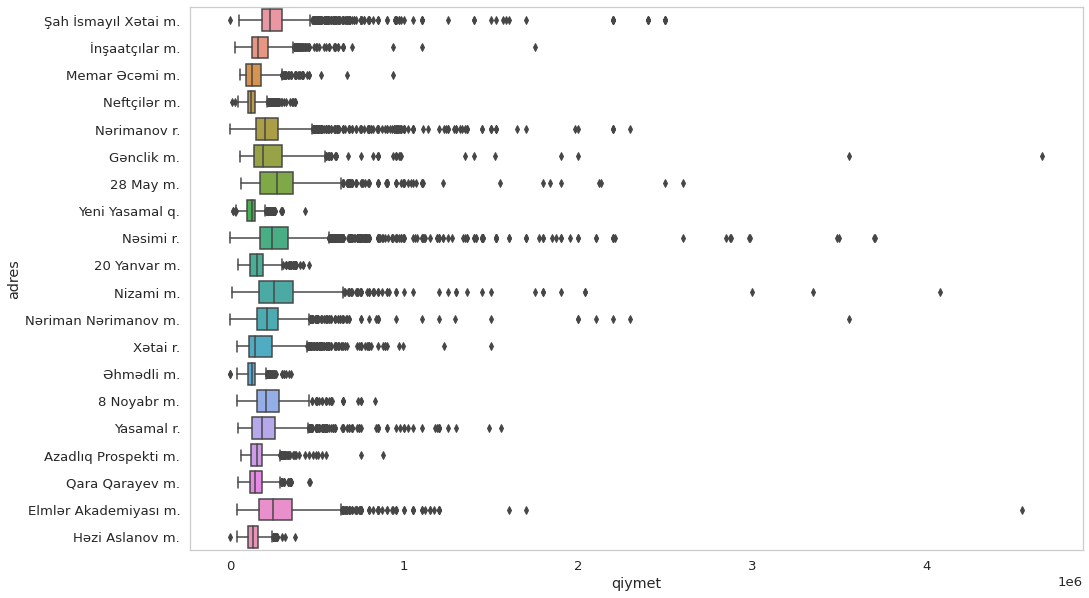

In [ ]:
plt.figure(figsize=(16,10))
sns.boxplot(data=adres_df, y="adres",x='qiymet')
plt.show()

#### Outlier treatment

In [ ]:
def get_low_high(data_series):
    Q1 = data_series.quantile(0.25)
    Q3 = data_series.quantile(0.75)
    IQR = Q3-Q1
    low = Q1 - 1.5*IQR
    high = Q3 + 1.5*IQR
    
    return low, high

In [ ]:
def replace_outliers_median(data,feature,inplace=False):
    temp_df = data.copy(deep=True)
    low,high=get_low_high(temp_df[feature])
    feature_median = temp_df[feature].median()
    temp_df[feature] = temp_df[feature].apply(lambda x: x if (x > low and x < high) else feature_median)
    if inplace:
        data = temp_df
    return temp_df

In [ ]:
def drop_outliers(data,feature,inplace=False):
    temp_df = data.copy(deep=True)
    low,high=get_low_high(temp_df[feature])
    feature_median = temp_df[feature].median()
    temp_df = temp_df[(temp_df[feature] > low) & (temp_df[feature] < high)]
    if inplace:
        data = temp_df
    return temp_df

In [ ]:
df.sahe.describe()

count    59336.000
mean       125.551
std       2248.432
min          2.000
25%         70.000
50%         97.000
75%        135.000
max     375000.000
Name: sahe, dtype: float64

In [ ]:
get_low_high(df.sahe)

(-27.5, 232.5)

In [ ]:
df = drop_outliers(df,'sahe')

In [ ]:
df.sahe.describe()

count   57799.000
mean      102.661
std        43.221
min         2.000
25%        69.000
50%        95.000
75%       130.000
max       232.400
Name: sahe, dtype: float64

In [ ]:
df.sahe.quantile(0.001)

27.0

In [ ]:
df.groupby('otaq_say').get_group(1)['sahe'].agg(['min','max','mean'])

min     15.000
max    110.000
mean    47.688
Name: sahe, dtype: float64

##### 15 kvm-den kicik olanlari drop ele

In [ ]:
df = df[df.sahe > 14]

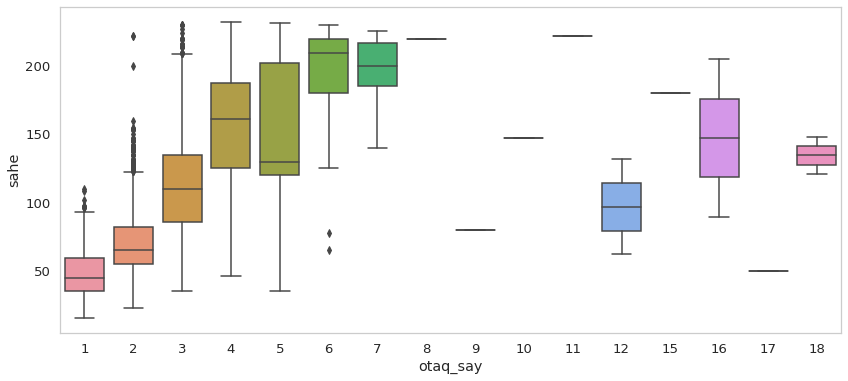

In [ ]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df,x='otaq_say',y='sahe')
plt.show()

In [ ]:
q3 = df.sahe.quantile(0.75)
q1 = df.sahe.quantile(0.25)
iqr = q3-q1


In [ ]:
df.groupby('otaq_say').get_group(1)['qiymet'].describe()

count     2441.000
mean     88867.633
std      36946.916
min      11000.000
25%      69500.000
50%      82000.000
75%     104000.000
max     750000.000
Name: qiymet, dtype: float64

##### 11 min azn-den kicik olan elanlari drop ele(kireye evler daxildir)

In [ ]:
df = df[df.qiymet >= 11000]

In [ ]:
df.qiymet.describe()

count     57787.000
mean     190699.998
std      114755.094
min       11000.000
25%      116500.000
50%      160000.000
75%      235000.000
max     3350000.000
Name: qiymet, dtype: float64

In [ ]:
df.shape

(57787, 15)

In [ ]:
df = df.drop('kvm_qiymet',axis=1)

In [ ]:
df = df.drop('ipoteka',axis=1)

In [ ]:
df = df.drop(columns=['satici','elan_basliq','info'],axis=1)

In [ ]:
df.head()

,kateqoriya,mertebe,otaq_say,sahe,qiymet,adres,baxis_say,cixarish,mertebe_bina,tecili
elan_id,,,,,,,,,,
2969337,Yeni tikili,2,5,110.000,248000,Şah İsmayıl Xətai m.,91,1,7,1
2801416,Yeni tikili,13,4,141.000,280000,İnşaatçılar m.,296,1,19,1
2903445,Köhnə tikili,3,2,58.000,86000,Memar Əcəmi m.,1030,1,5,1
2969332,Yeni tikili,9,3,194.000,475000,Şah İsmayıl Xətai m.,79,1,15,0
2969329,Köhnə tikili,1,1,35.000,58500,Neftçilər m.,436,1,5,0


In [ ]:
# qiymeti logla, kateqoriya, adres encodla

In [ ]:
df.kateqoriya = pd.get_dummies(df.kateqoriya,drop_first=True)

In [ ]:
df.head()

,kateqoriya,mertebe,otaq_say,sahe,qiymet,adres,baxis_say,cixarish,mertebe_bina,tecili
elan_id,,,,,,,,,,
2969337,1,2,5,110.000,248000,Şah İsmayıl Xətai m.,91,1,7,1
2801416,1,13,4,141.000,280000,İnşaatçılar m.,296,1,19,1
2903445,0,3,2,58.000,86000,Memar Əcəmi m.,1030,1,5,1
2969332,1,9,3,194.000,475000,Şah İsmayıl Xətai m.,79,1,15,0
2969329,0,1,1,35.000,58500,Neftçilər m.,436,1,5,0


In [ ]:
adres_freq_df = df.adres.value_counts().reset_index().rename(columns={'index':'adres','adres':'frequency'})

In [ ]:
adres_freq_df.head()

,adres,frequency
0,Nəsimi r.,4895
1,Nərimanov r.,4062
2,İnşaatçılar m.,3695
3,Şah İsmayıl Xətai m.,2893
4,Nəriman Nərimanov m.,2688


In [ ]:
adres_dict = dict()

In [ ]:
for index, row in adres_freq_df.iterrows():
    adres_dict[row['adres']] = row['frequency']

In [ ]:
df.adres = df.adres.apply(lambda x: adres_dict[x])

In [ ]:
df.head()

,kateqoriya,mertebe,otaq_say,sahe,qiymet,adres,baxis_say,cixarish,mertebe_bina,tecili
elan_id,,,,,,,,,,
2969337,1,2,5,110.000,248000,2893,91,1,7,1
2801416,1,13,4,141.000,280000,3695,296,1,19,1
2903445,0,3,2,58.000,86000,2076,1030,1,5,1
2969332,1,9,3,194.000,475000,2893,79,1,15,0
2969329,0,1,1,35.000,58500,1381,436,1,5,0


In [ ]:
# qiymeti loglayiriq performans ucun
df.qiymet = df.qiymet.apply(np.log)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('qiymet',axis=1), df.qiymet, test_size=0.2)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [ ]:
print(f"Train data score: {lr.score(X_train,y_train)}\nTest data score: {lr.score(X_test,y_test)}")

Train data score: 0.721893187876723
Test data score: 0.7286249513484493


In [ ]:
lr_predicts = lr.predict(X_test)
mean_absolute_error(y_test,np.exp(lr_predicts)), median_absolute_error(y_test,np.exp(lr_predicts))

(185814.44730361327, 154867.69652373972)

In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)

RandomForestRegressor()

In [ ]:
print(f"Train data score: {rf.score(X_train,y_train)}\nTest data score: {rf.score(X_test,y_test)}")

Train data score: 0.9827609107444483
Test data score: 0.8788115716114281


In [ ]:
rf_predicts = rf.predict(X_test)
mean_absolute_error(y_test,np.exp(rf_predicts)), median_absolute_error(y_test,np.exp(rf_predicts))

(188469.62002394258, 161168.4885896754)

In [ ]:
dt = DecisionTreeRegressor()
dt.fit(X_train,y_train)

DecisionTreeRegressor()

In [ ]:
print(f"Train data score: {dt.score(X_train,y_train)}\nTest data score: {dt.score(X_test,y_test)}")

Train data score: 0.9999940883289967
Test data score: 0.7517815154738274


In [ ]:
dt_predicts = dt.predict(X_test)
mean_absolute_error(y_test,np.exp(dt_predicts)), median_absolute_error(y_test,np.exp(dt_predicts))

(193488.2341452083, 161937.9377683907)

In [ ]:
ridge = Ridge()
ridge.fit(X_train,y_train)

Ridge()

In [ ]:
print(f"Train data score: {ridge.score(X_train,y_train)}\nTest data score: {ridge.score(X_test,y_test)}")

Train data score: 0.7218931870891814
Test data score: 0.7286254867796969


In [ ]:
ridge_predicts = ridge.predict(X_test)
mean_absolute_error(y_test,np.exp(ridge_predicts)), median_absolute_error(y_test,np.exp(ridge_predicts))

(185813.56043059658, 154868.27643101534)